# CarND P4: Advanced Lane finding
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
#importing packages relevant to this project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
%matplotlib inline

## Camera Calibration

### 1. Loading the images
A simple method to load the images is defined. This method is used to load both the calibration as well as the test images

In [2]:
def load_images(names_path, names_list):
    images = []
    for name in names_list:
        images.append(cv2.imread(names_path + name))
    return images

### 2. Calibrating the camera
All the calibration images are loaded. The grid is a non conventional 9x6 grid.
The Flowchart for Camera calibration is illustrated below.

![Calibration Pipeline](./writeup_helpers/Calibration.png "Calibration")


In [3]:
# Path Containing Calibration images
calibration_path = 'camera_cal/'

# Grid Dimensions
nx = 9
ny = 6

# Generate a standard 9x6 grid
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

calibration_image_names = os.listdir(calibration_path)


calibration_images = load_images(calibration_path, 
                                 calibration_image_names)
objpoints = []
imgpoints = []
for i in range(len(calibration_images)):
    image = calibration_images[i]
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(image, (nx,ny),None)

    # If corners were found, add an instance of the objectpoints representing a grid
    # Add Detected Corners to ImagePoints
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw corners and show
        img = cv2.drawChessboardCorners(image, (nx,ny), corners,ret)

In [4]:
# Compute the Calibration Matrices
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[::-1],None,None)

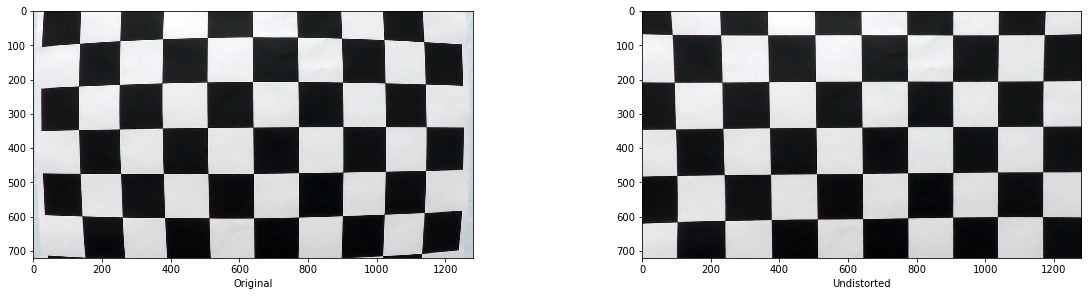

In [5]:
# Check for correct Calibration by testing on a reference checkerboard image

img = np.copy(calibration_images[0])
# undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Show undistorted and original images for verification
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.xlabel('Original')
plt.imshow(img, cmap='gray')
plt.subplot(222)
plt.imshow(dst, cmap = 'gray')
plt.xlabel('Undistorted')

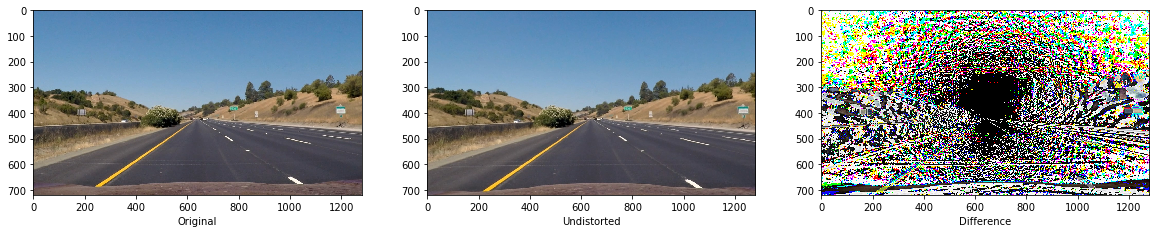

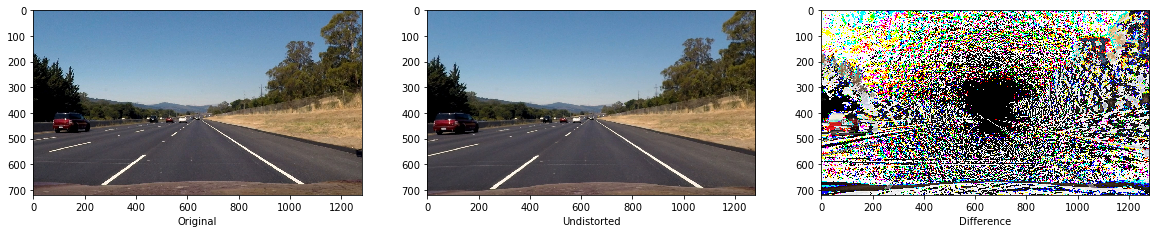

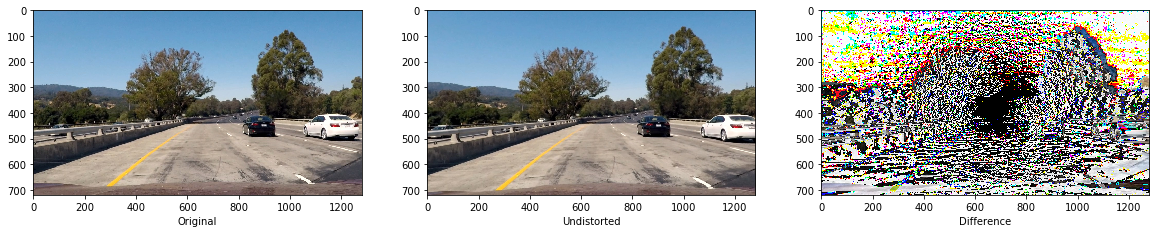

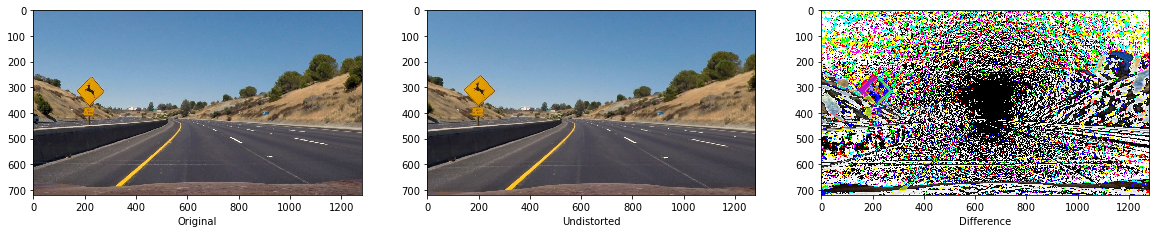

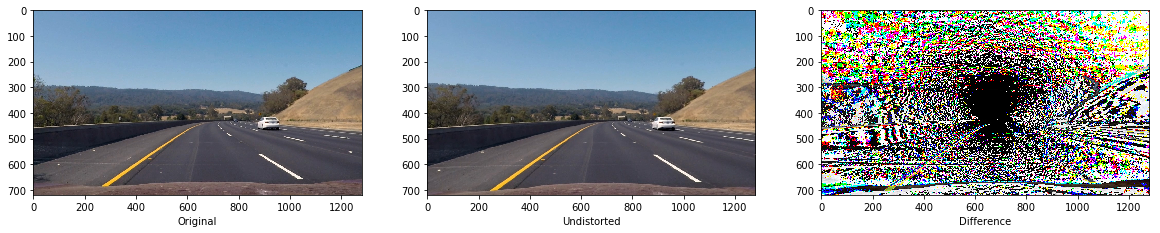

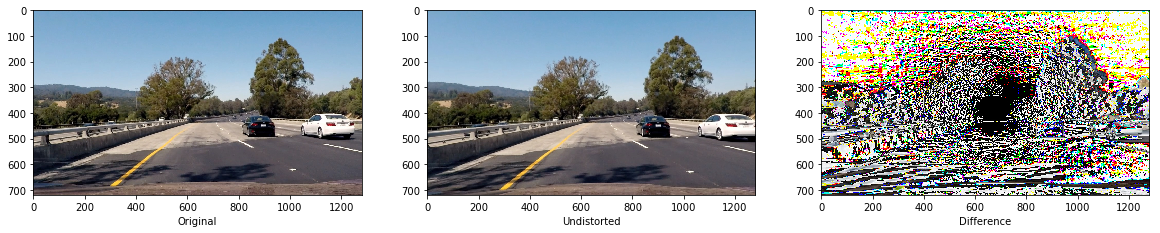

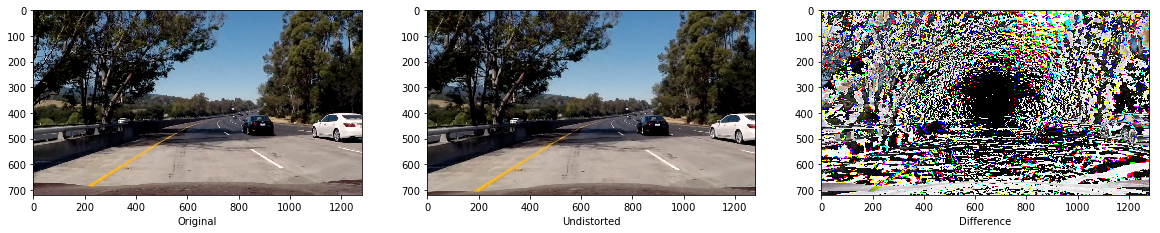

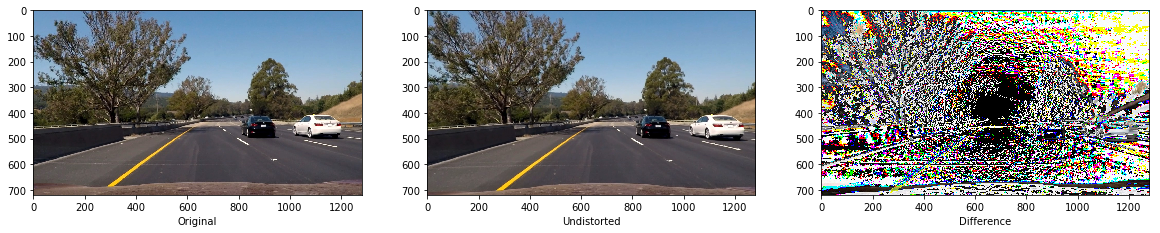

In [6]:
# Test on the Test images
test_path = 'test_images/'
test_file_names = os.listdir(test_path)
test_images = load_images(test_path,test_file_names)

# Undistort all the test images and visualize the difference
for i in range(len(test_images)):
    img = cv2.cvtColor(test_images[i],cv2.COLOR_BGR2RGB)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.figure(i,figsize=(20,10))
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.xlabel('Original')
    plt.subplot(132)
    plt.imshow(dst, cmap = 'gray')
    plt.xlabel('Undistorted')
    plt.subplot(133)
    plt.imshow(img-dst, cmap = 'gray')
    plt.xlabel('Difference')
    test_images[i]=dst


### 3. Calculating the Perspective Transform
The Inverse perspective transform is calculated using the four point method. An image is chosen deliberately with straight lanes so that the points are empirically tuned to get parallel lane lines and verify the IPM Visually.

![Perspective Transform](./writeup_helpers/ipm.png "Perspective")

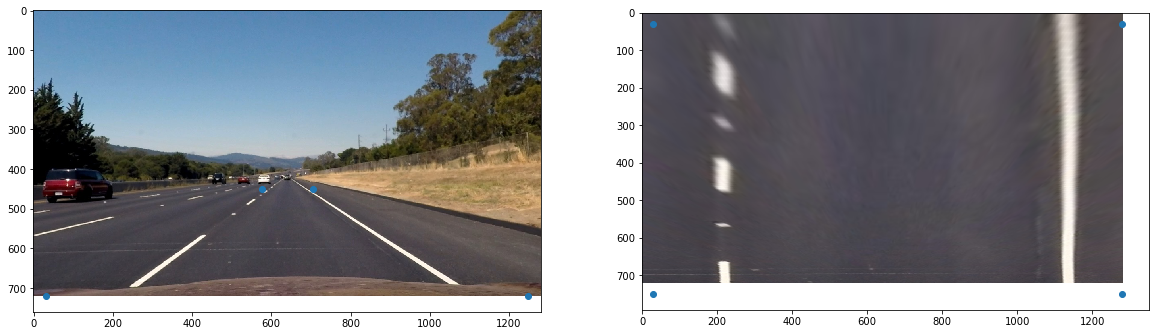

In [7]:
# Create Source and Destination points for 4 point Perspective Transform
img = test_images[1]
img_size = img.shape

# upper and lower bounds for the height
height_ub = np.uint(img_size[0]/1.6)
height_lb = np.uint(img_size[0])

# Define points in perspective
top_scale_factor = 0.1
bottom_scale_factor = 0.95

center_point = np.uint(img_size[1]/2)
top_left = center_point - top_scale_factor*np.uint(img_size[1]/2)
top_right = center_point + top_scale_factor*np.uint(img_size[1]/2)
bottom_left = center_point - bottom_scale_factor*np.uint(img_size[1]/2)
bottom_right = center_point + bottom_scale_factor*np.uint(img_size[1]/2)

src = np.float32([[bottom_left,height_lb],
                  [bottom_right,height_lb],
                  [top_right, height_ub],
                  [top_left,height_ub]])

dst = np.float32([[30,img_size[0]+30],[img_size[1],img_size[0]+30],
                  [img_size[1],30],[30,30]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.scatter(x=src[:,0],y=src[:,1])

plt.subplot(122)
warped = cv2.warpPerspective(img, M,
                          (img.shape[1],img.shape[0]),
                          flags=cv2.INTER_LINEAR)
plt.imshow(warped,cmap='gray')
plt.scatter(x=dst[:,0],y=dst[:,1])



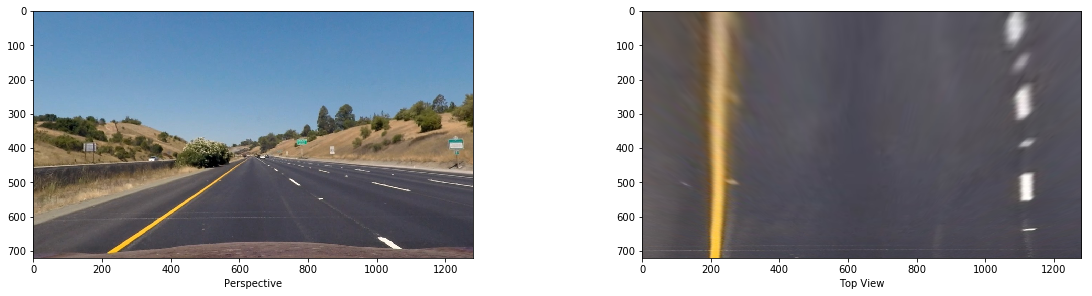

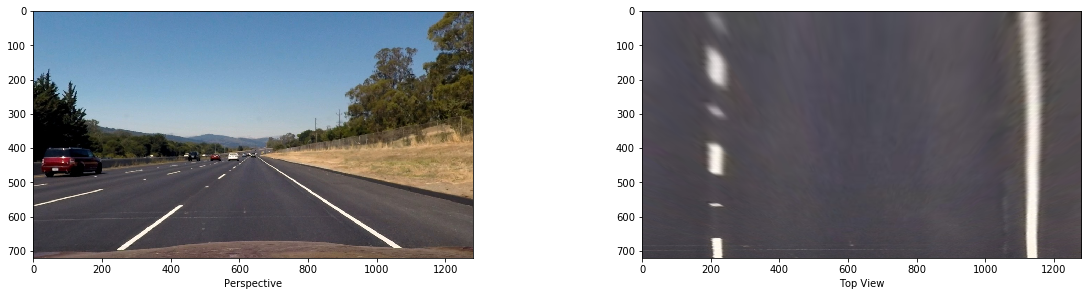

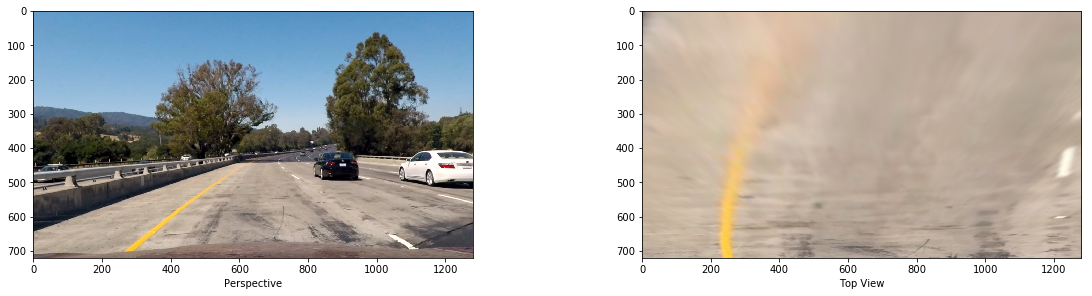

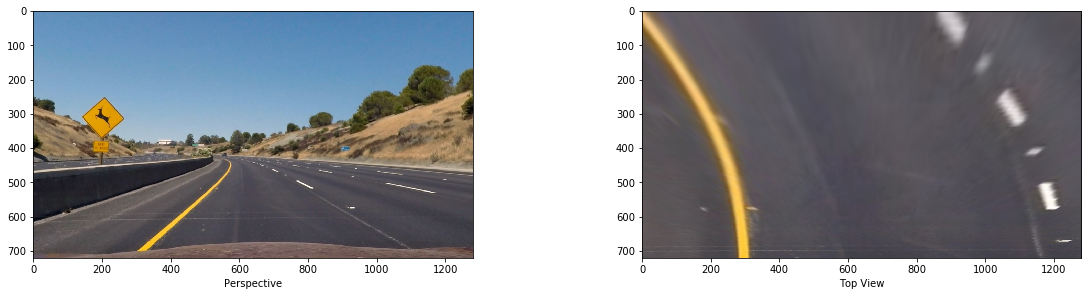

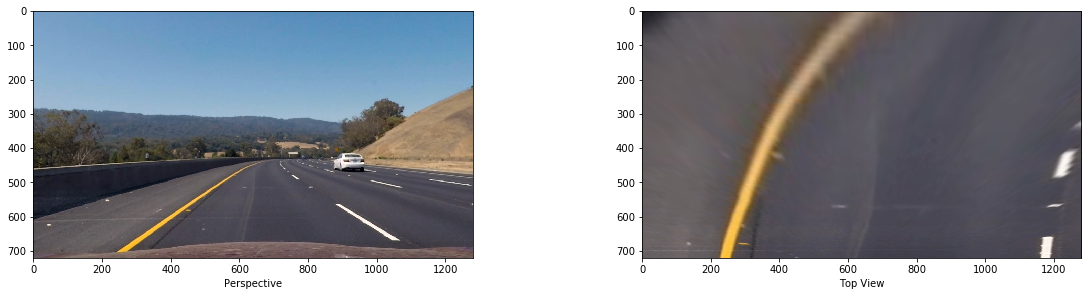

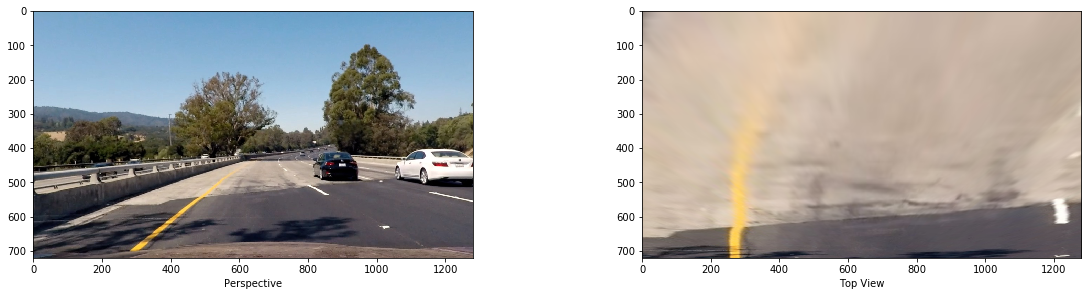

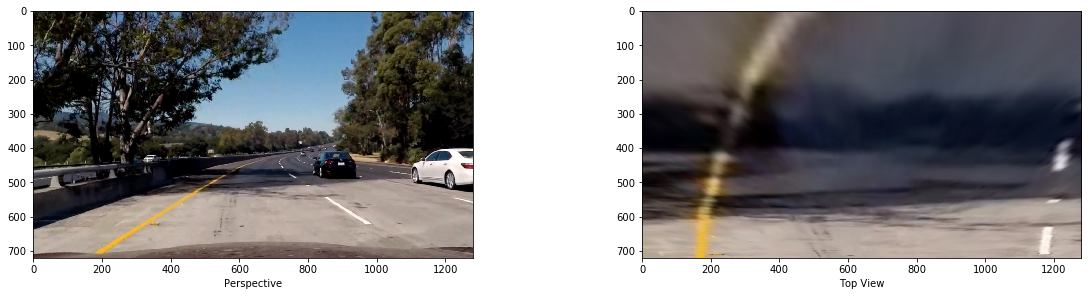

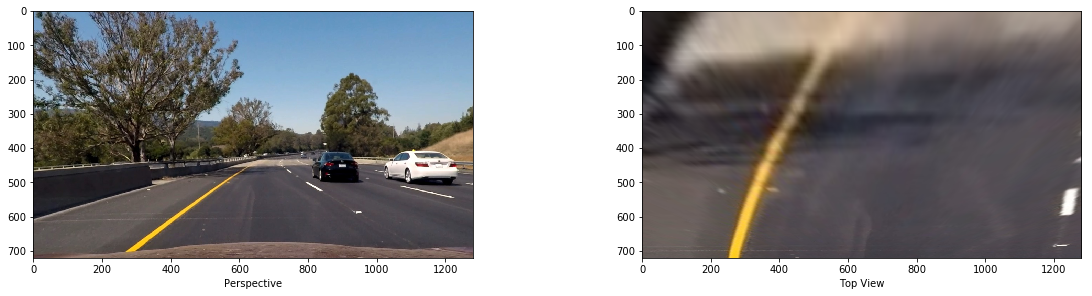

In [8]:
# Load up test images to test the perspective transform calculated
ipm_images = []
for i in range(len(test_images)):
    img = test_images[i]
    
    warped = cv2.warpPerspective(img, M, 
                                        (img.shape[1],img.shape[0]),
                                        flags=cv2.INTER_LINEAR)
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.imshow(img,cmap = 'gray')
    plt.xlabel('Perspective')
    plt.subplot(222)
    plt.imshow(warped,cmap='gray')
    plt.xlabel('Top View')
    ipm_images.append(warped)

### 4. Color space segmentation
HLS and LAB spaces were used to reliably separate lane markings based on color.
The Flowchart is presented below

![Color Space Segmentation](./writeup_helpers/color_pipeline.png "Color Based Segmentation")

In [9]:
# Color Space Filter Pipeline
def color_pipeline(img):
    
    # Convert to HLS
    image_HLS = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

    # Only use L Channel of HLS image
    image_HLS = image_HLS[:,:,1]

    # Define upper and lower bounds of L channel
    hls_lb = 210
    hls_ub = 255
    
    # Create binary mask for HLS image
    hls_mask = np.zeros_like(image_HLS)
    hls_mask[(image_HLS > hls_lb) & (image_HLS <= hls_ub)] = 1
    
    # Convert to LAB
    image_LAB = image_HLS = cv2.cvtColor(img,cv2.COLOR_RGB2Lab)
    # Only use B channel of LAB image
    image_LAB = image_LAB[:,:,2]

    # Define upper and lower bounds of B channel
    lab_lb  = 145
    lab_ub = 255
    
    # Create binary mask for LAB image
    lab_mask = np.zeros_like(image_LAB)
    lab_mask[(image_LAB > lab_lb) & (image_LAB <= lab_ub)] = 1
    
    # Combine the masks
    color_mask = np.zeros_like(image_LAB)
    color_mask[(lab_mask == 1) | (hls_mask == 1)] = 1
     
    return color_mask

### 5. Gradient based Segmentation
A sobel filter with x gradient only was used. The gradient based segmentation is to be performed on the top view (perspective transformed ) images so only a magnitude gradient in the x direction is relevant to the problem.

In [10]:
# Gradient Threshold Filter Pipeline
def gradient_pipeline(img):
    # Convert to Grayscale for sobel filter
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Since we are operating on the Warped images from top view, 
    # we can only work with x gradient magnitude
    
    # Find X gradient
    sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=5)
    
    # Get absolute value
    abs_sobelx = np.absolute(sobel_x)
    
    # Scale it from 0 to 255
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Define lower and upper bounds for the X gradient
    xgrad_lb = 20
    xgrad_ub = 255
    
    # Create binary Mask
    gradient_mask = np.zeros_like(scaled_sobelx)
    gradient_mask[(scaled_sobelx > xgrad_lb) & (scaled_sobelx <= xgrad_ub)] = 1
    
    return gradient_mask


### 6. Combination of Masks

The Masks are combined using a simple or combination. The underlying assumption is that either gradient or Color space segmentation should be able to pick up the lane markers.
![Masks](./writeup_helpers/masks_new.png "Lane Mask")

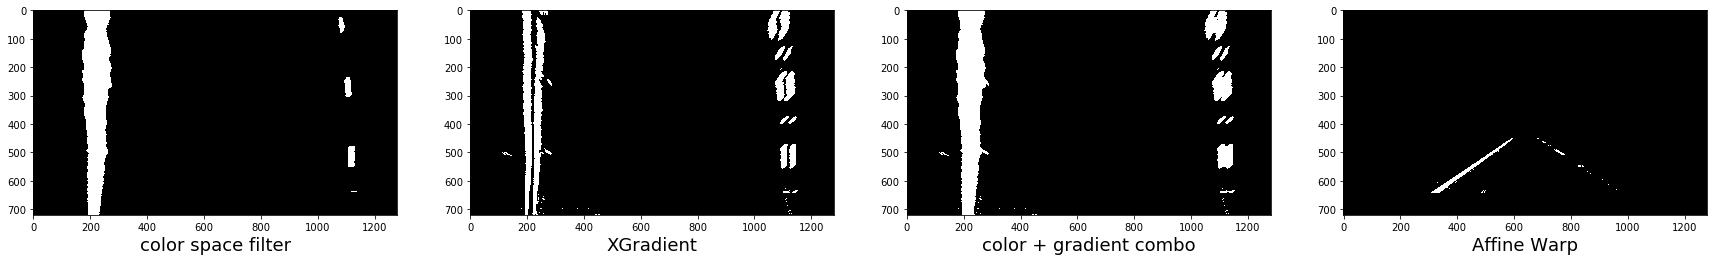

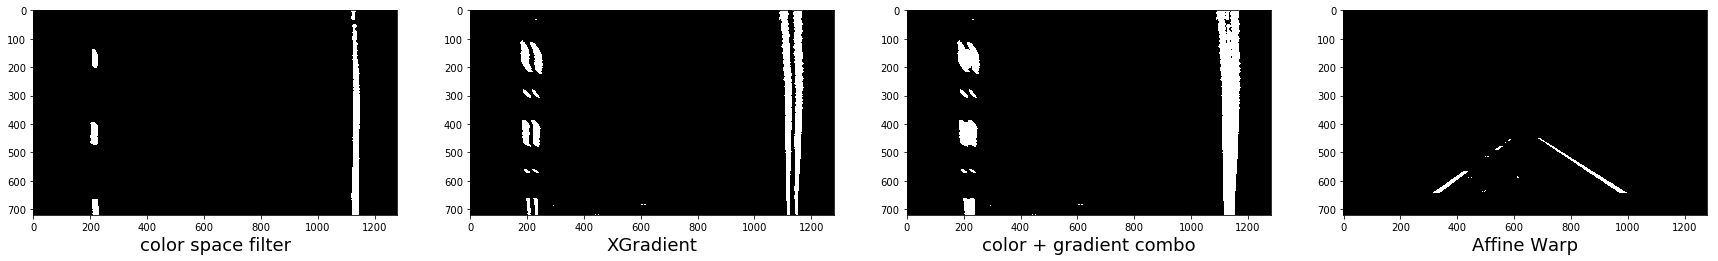

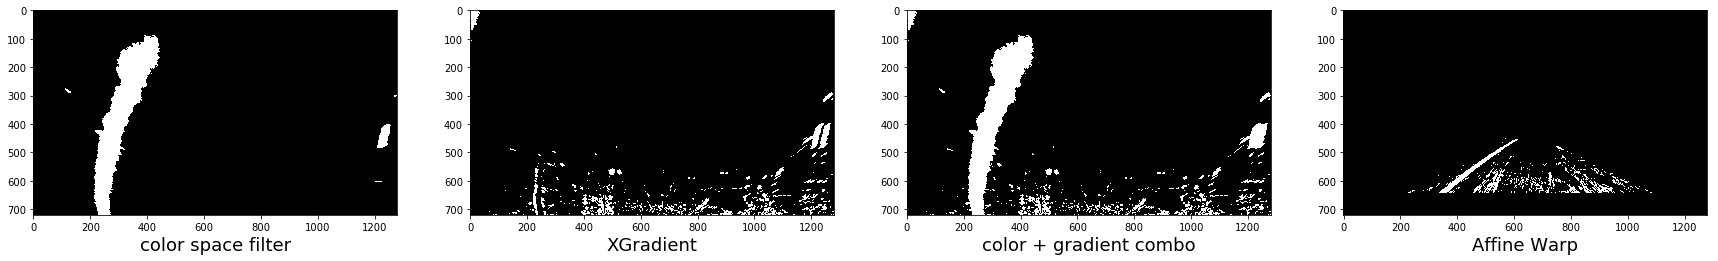

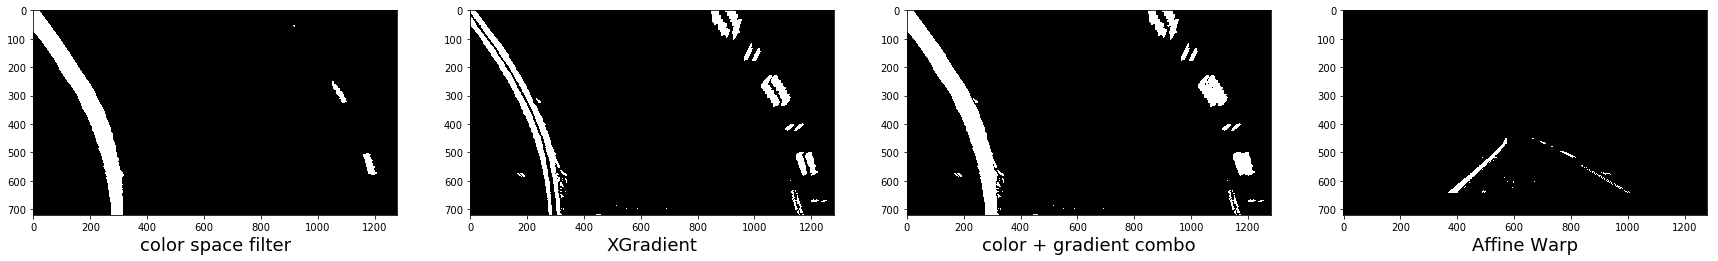

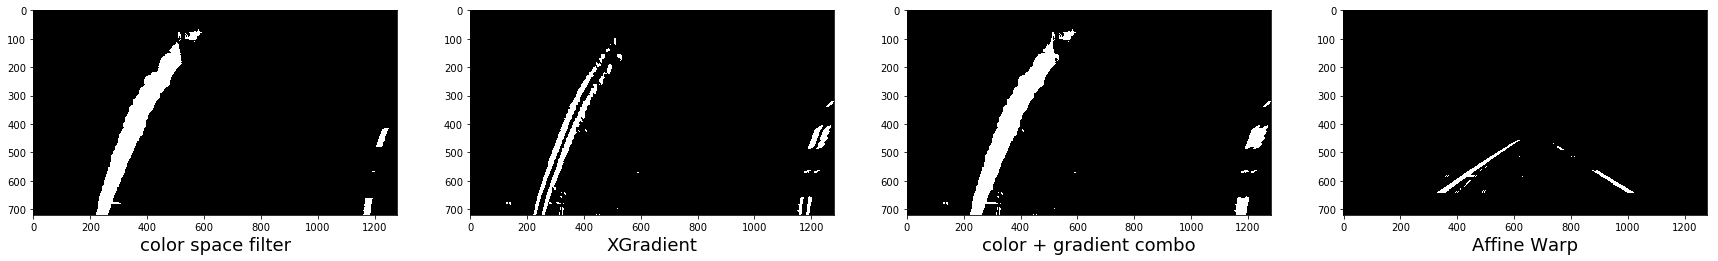

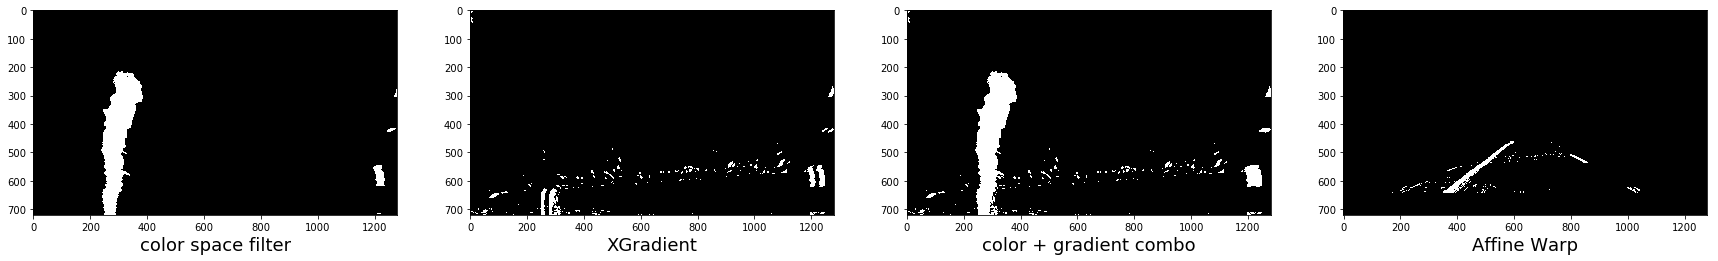

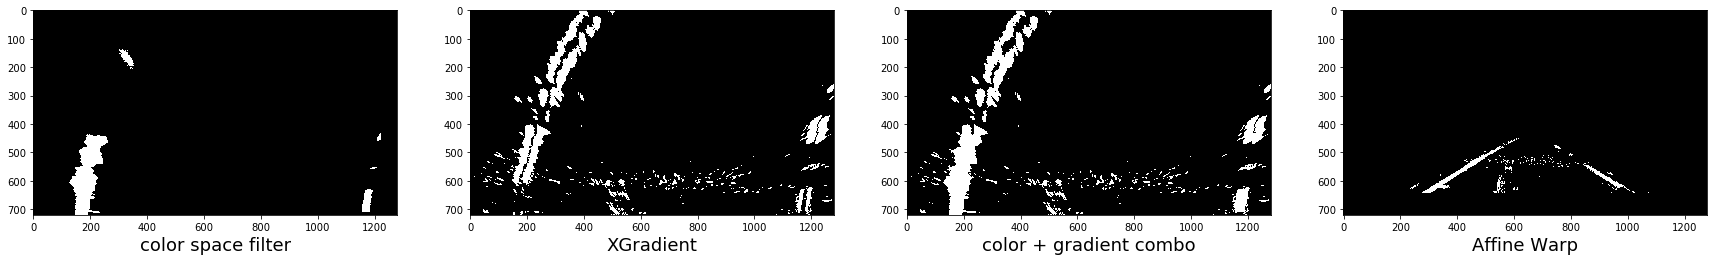

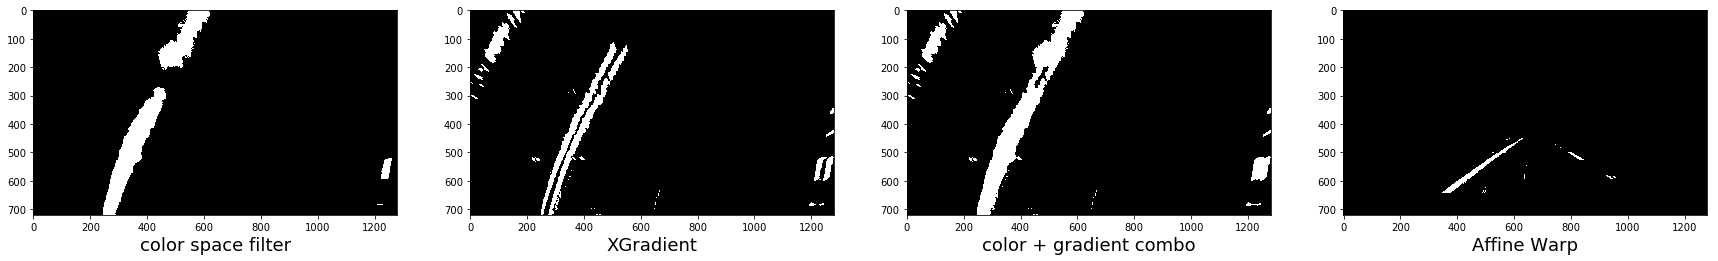

In [11]:
# Test both color and gradient based pipelines for segmentation

lane_masks = []
for image in ipm_images:
    
    image = cv2.GaussianBlur(image, (5,5), 0)
    color_mask = color_pipeline(image)

    grad_mask = gradient_pipeline(image)

    plt.figure(figsize=(30,15))
    plt.subplot(141)
    plt.xlabel('color space filter',fontsize=18)
    plt.imshow(color_mask,cmap='gray')
    plt.subplot(142)
    plt.xlabel('XGradient',fontsize=18)
    plt.imshow(grad_mask,cmap='gray')
    plt.subplot(143)
    
    lane_mask  = np.zeros_like(color_mask)
    lane_mask [ ( color_mask == 1 ) | (grad_mask == 1 )] = 1
    plt.xlabel('color + gradient combo',fontsize=18)
    plt.imshow(lane_mask,cmap = 'gray')
    plt.subplot(144)
    plt.xlabel('Affine Warp',fontsize=18)
    lane_mask_in_perspective = cv2.warpPerspective(lane_mask, Minv, (image.shape[1], image.shape[0]))
    plt.imshow(lane_mask_in_perspective,cmap = 'gray')
    lane_masks.append(lane_mask)
    
    plt.show()

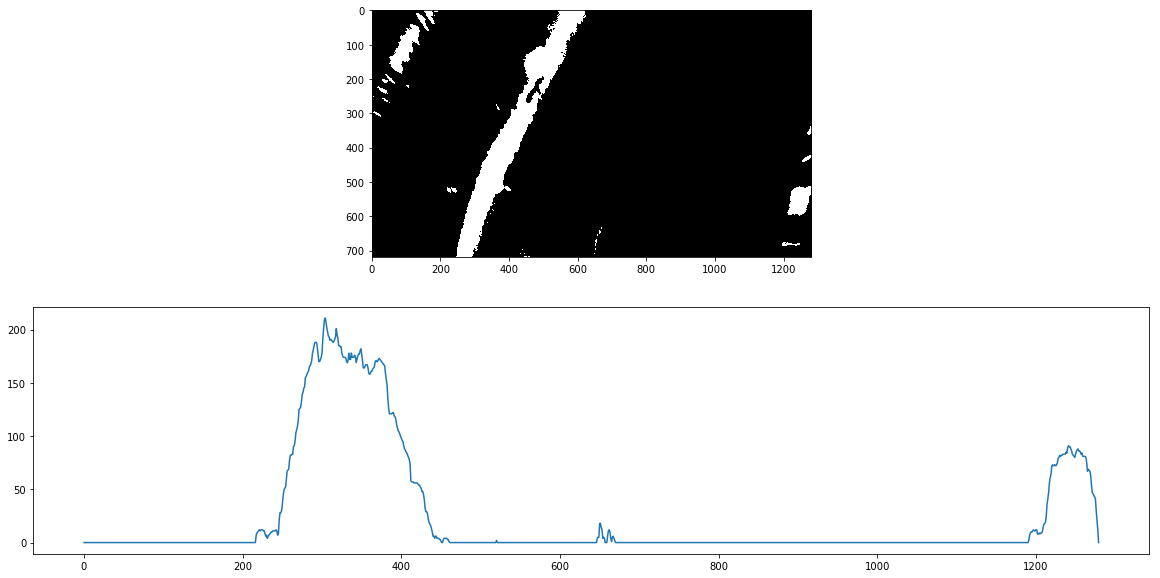

In [12]:
# Visualize the histogram
img = lane_masks[np.random.randint(0,len(lane_masks))]
histogram = np.sum(img[np.int32(img.shape[0]/2):,:], axis=0)
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.imshow(img,cmap='gray')
plt.subplot(212)
plt.plot(histogram)

In [13]:
# Line Class to track lines
from collections import deque
class Line:

    def __init__(self):

        # was the line detected in the last iteration?

        self.detected = False

        # x values of the last n fits of the line

        self.recent_xfitted = deque([], 8)

        # average x values of the fitted line over the last n iterations

        self.bestx = None

        # polynomial coefficients for the most recent fit

        self.current_fit = [np.array([False])]

        # x values for detected line pixels

        self.allx = None

        # y values for detected line pixels

        self.ally = None

    def track_line(
        self,
        x,
        y,
        fit_polynomial,
        xfit,
        curv,
        ):
        
        self.detected = True
        self.allx = x
        self.ally = y
        self.current_fit = fit_polynomial
        self.recent_xfitted.append(xfit)
        self.bestx = np.mean(self.recent_xfitted, axis=0)

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### 7. Detect and track lanes
The lane mask created by the combination of the gradient and the color masks is used to extract lane points by using the sliding window based approach on the histogram. The frame is vertically divided into 12 parts. and a moving window approach as instructed in the project help materials.



In [15]:
# Find lane points
def lane_points_finder(binary_warped, minpix = 50, margin =100):
    
    histogram = np.sum(binary_warped[np.int32(binary_warped.shape[0]/2):,:], axis=0)    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
               
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return leftx, lefty, rightx, righty

In [16]:
# Track lane points: To be used if last frame lane detection was successful
def lane_points_tracker(binary_warped, left_fit, right_fit, minpix = 50, margin =100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    # Use known fits to generate new points
    left_lane_inds = ((nonzerox >
                       (left_fit[0]*(nonzeroy**2) +
                        left_fit[1]*nonzeroy +
                        left_fit[2] - margin)) &
                      (nonzerox <
                       (left_fit[0]*(nonzeroy**2) +
                        left_fit[1]*nonzeroy +
                        left_fit[2] + margin)))
    
    right_lane_inds = ((nonzerox >
                        (right_fit[0]*(nonzeroy**2) +
                         right_fit[1]*nonzeroy +
                         right_fit[2] - margin)) &
                       (nonzerox <
                        (right_fit[0]*(nonzeroy**2) +
                         right_fit[1]*nonzeroy +
                         right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [17]:
# Helper Functions for lane Extraction and fitting

# Function to get lane polynomials
def get_lane_polynomial(leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each set of points
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

# Function to get Lane polynomial for scaling to real world space
def get_scaled_lane_polynomial(leftx, lefty, rightx, righty):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return left_fit, right_fit

# Pad lane points by margin
def get_padded_lane_points(binary_image, left_fitx, right_fitx, margin = 100):
    
    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
    # Create points by padding with Margin
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    return left_line_pts, right_line_pts
    
# Get X Coordinates of lane points
def get_lane_xfits(binary_image, left_fit, right_fit, margin = 100):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
    
    # Generate x points based on coefficients
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx,right_fitx

# Compute curvature based on polynomial
def get_curvature(binary_warped, left_fit, right_fit):
    y_eval = np.float32(binary_warped.shape[0] - 1)
    left_curverad = ((1 + (2*left_fit[0]*y_eval +
                    left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval +
                     right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

# Get curvature in real world frame
def get_curvature_scaled(binary_warped, left_fit, right_fit):
    y_eval = np.float32(binary_warped.shape[0] - 1)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix +
                           left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix +
                            right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

# Get Distance from center
def get_distance_from_center(binary_image, left_fit, right_fit):
    y_eval = np.float32(binary_image.shape[0] - 1)
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    
    
    leftx = left_fit[0]*(y_eval)**2 + left_fit[1]*y_eval+ left_fit[2]
    rightx = right_fit[0]*(y_eval)**2 + right_fit[1]*y_eval + right_fit[2]
    
    center = binary_image.shape[1] / 2.
    dl = (center - leftx) * xm_per_pix
    dr = (rightx - center) * xm_per_pix
    return dl, dr


# Check whether lane points are sane
def check_lane_sanity(left_curv, right_curv, left_fit, right_fit):
    # check curvature
    if left_curv >= 200 and right_curv >= 200:
        flag_curv = True
    else:
        flag_curv = False
    # check parallel
    left_slope = left_fit[0]
    right_slope = right_fit[0]
    if np.absolute(right_slope - left_slope) <= 9e-4:
        flag_paral = True
    else:
        flag_paral = False
        
    return (flag_curv and flag_paral)

In [18]:
def lane_finder(binary_image, left, right):

    # Set the width of the windows +/- margin

    margin = 30

    # Set minimum number of pixels found to recenter window

    minpix = 50

    # If lines are detected, only track
    # If not Initialize or rely on best fit by history
    if left.detected and right.detected:
        (left_x, left_y, right_x, right_y) = \
            lane_points_tracker(binary_image, left.current_fit,
                                right.current_fit, minpix, margin)
    else:
        (left_x, left_y, right_x, right_y) = \
            lane_points_finder(binary_image, minpix, margin)

    # Get Polynomial
    (left_polynomial, right_polynomial) = get_lane_polynomial(left_x,
            left_y, right_x, right_y)

    # Get Scaled Polynomial
    (left_fit_scaled, right_fit_scaled) = \
        get_scaled_lane_polynomial(left_x, left_y, right_x, right_y)

    # Get X co-ordinate
    (left_xfit, right_xfit) = get_lane_xfits(img, left_polynomial,
            right_polynomial)

    # Get Curvature
    (left_radius, right_radius) = get_curvature_scaled(img,
            left_fit_scaled, right_fit_scaled)

    # If lane lines are parallel and the curvature is within bounds
    if check_lane_sanity(left_radius, right_radius, left_polynomial,
                         right_polynomial):
        left.track_line(left_x, left_y, left_polynomial, left_xfit,
                        left_radius)
        right.track_line(right_x, right_y, right_polynomial,
                         right_xfit, right_radius)
    else:
        left.detected = False
        right.detected = False

    ploty = np.linspace(0, binary_image.shape[0] - 1,
                        binary_image.shape[0])

    # Create an image to draw the lane on
    binary_color = np.zeros_like(binary_image).astype(np.uint8)
    color_img = np.dstack((binary_color, binary_color, binary_color))

    # Create an output image to draw lines on and  visualize the result
    out_img = np.dstack((binary_image, binary_image, binary_image)) \
        * 255
    window_img = np.zeros_like(out_img)
    out_img = np.zeros_like(window_img)
    
    # Pad lines to draw on lanes
    (padded_lines_left, padded_lines_right) = \
        get_padded_lane_points(binary_image, left.bestx, right.bestx)
    points_left = np.array([np.transpose(np.vstack([left.bestx,
                           ploty]))])
    points_right = \
        np.array([np.flipud(np.transpose(np.vstack([right.bestx,
                 ploty])))])

        
    # Draw the lane region
    points = np.hstack((points_left, points_right))
    cv2.fillPoly(color_img, np.int_([points]), (0, 255, 0))

    # Draw the Lane Lines
    cv2.fillPoly(window_img, np.int_([padded_lines_left]), (0, 255,
                 255))
    cv2.fillPoly(window_img, np.int_([padded_lines_right]), (0, 255,
                 255))

    # Combine the outputs
    result = cv2.addWeighted(out_img, 1, window_img, 0.7, 0)
    result = cv2.addWeighted(result, 1, color_img, 0.5, 0)

    # Compute radius of Curvature in real world
    y_eval = np.max(ploty)
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Calculate the new radii of curvature
    left_curverad = (1 + (2 * left_fit_scaled[0] * y_eval * ym_per_pix
                     + left_fit_scaled[1]) ** 2) ** 1.5 / np.absolute(2
            * left_fit_scaled[0])
    right_curverad = (1 + (2 * right_fit_scaled[0] * y_eval
                      * ym_per_pix + right_fit_scaled[1]) ** 2) ** 1.5 \
        / np.absolute(2 * right_fit_scaled[0])
    
    # Get Distance from left and right from center
    dl, dr = get_distance_from_center(binary_image,
                                      left_fit=left.current_fit,
                                      right_fit=right.current_fit, )

    return result, left_curverad, right_curverad,dl,dr

In [19]:
# Global lines to use
left_line = Line()
right_line = Line()

# Function to process incoming video frame
def annotate_frame(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    image_warped = cv2.warpPerspective(image, M, 
                                        (img.shape[1],img.shape[0]),
                                        flags=cv2.INTER_LINEAR)
    
    global left_line
    global right_line
    
    # Get Gradient Mask
    gradient_mask = gradient_pipeline(image_warped)
    
    # Get Color Mask
    color_mask = color_pipeline(image_warped)
    
    # Combine both
    lane_mask  = np.zeros_like(color_mask)
    lane_mask [ (color_mask == 1) | (gradient_mask == 1) ] = 1
    
    # Find lane 
    disp_image,left_curverad, right_curverad, dl, dr = lane_finder(lane_mask, left_line, right_line)

    # Apply perspective transform
    disp_image = cv2.warpPerspective(disp_image, Minv, 
                                        (image.shape[1],image.shape[0]),
                                        flags=cv2.INTER_LINEAR)
    
    # Add the result to the original image
    result = cv2.addWeighted(image,1.0, disp_image,0.5,0)
    
    # Annotate curvature on image
    radText = 'Left_Radius:' + "%.10s" % (left_curverad) + " Right_Radius:" +"%.10s"%(right_curverad)
    distText = 'Left_Distance:' + "%.10s" % (dl) + " Right_Distance:" +"%.10s"%(dr)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, radText,(50,50), font, 1,(255,255,255),2)
    cv2.putText(result, distText,(50,150), font, 1,(255,255,255),2)

    # Show image for visualization
    cv2.imshow('win', result)
    cv2.waitKey(1)
    return cv2.cvtColor(result,cv2.COLOR_RGB2BGR)

### 8. Test and Visualize the Lane Marking pipeline
The Entire Pipeline as described above, is tested on all the test images for the purpose of testing and tuning
![Pipeline](./writeup_helpers/lane_pipeline_1.png "Pipeline 1")
![Pipeline](./writeup_helpers/lane_pipeline_2.png "Pipeline 2")

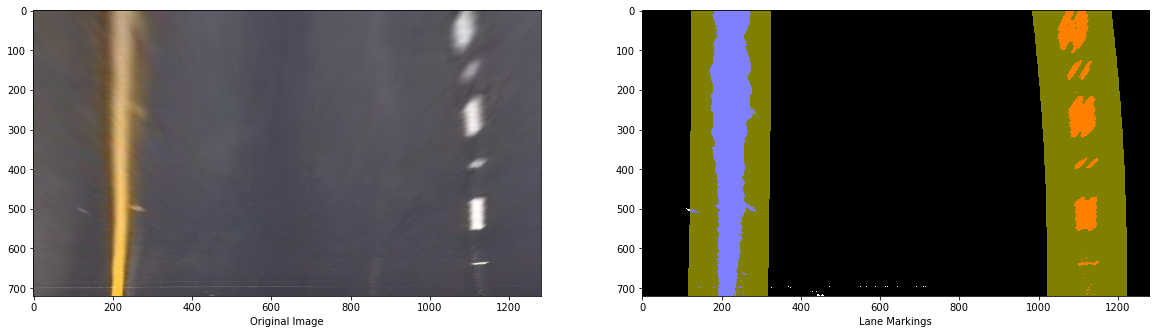

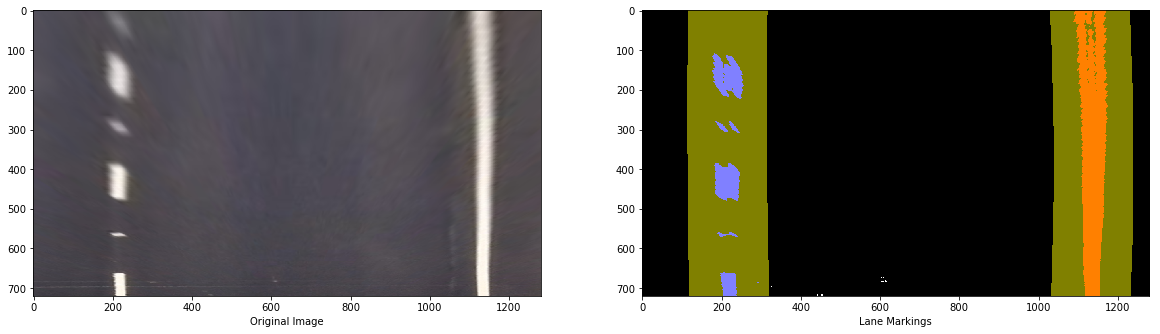

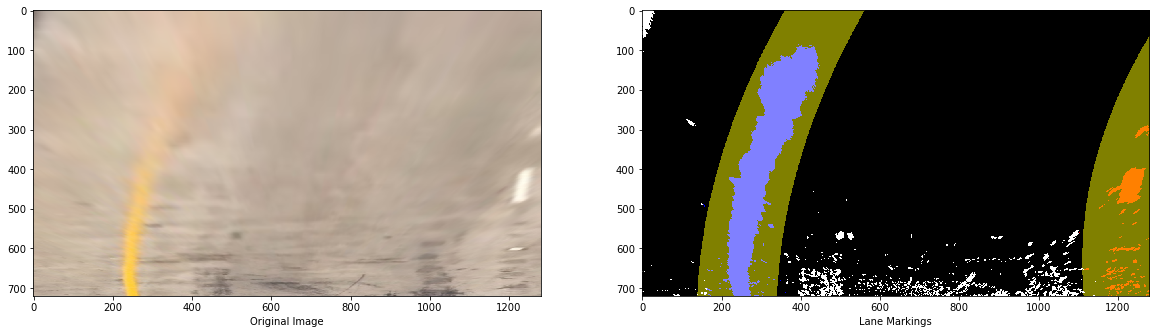

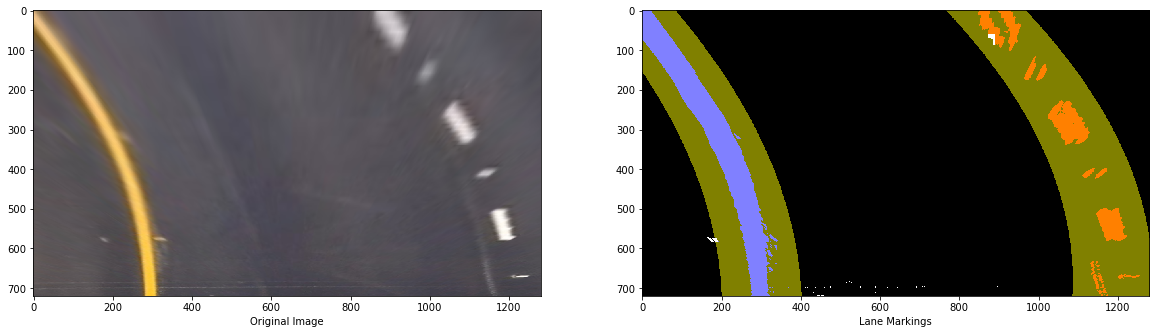

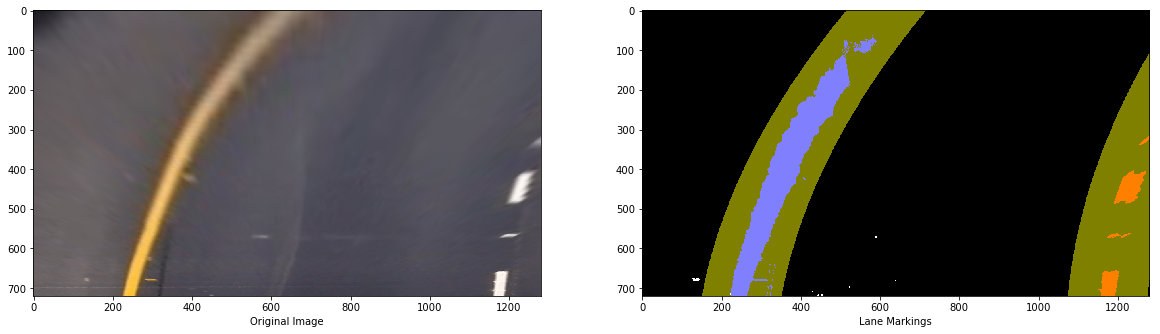

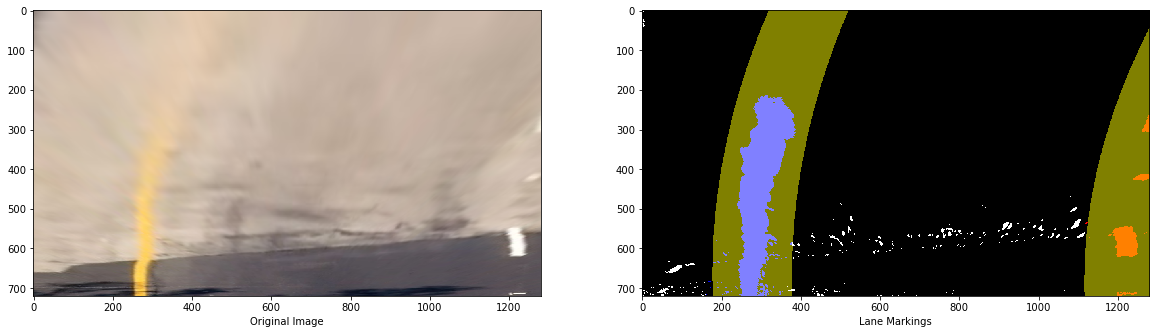

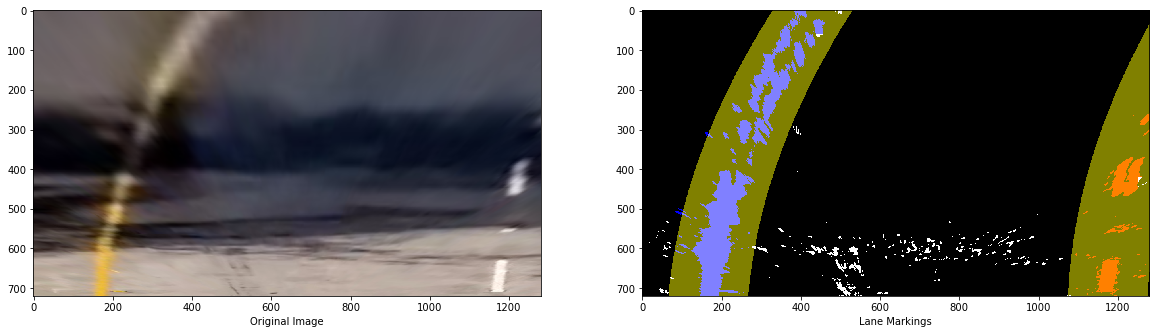

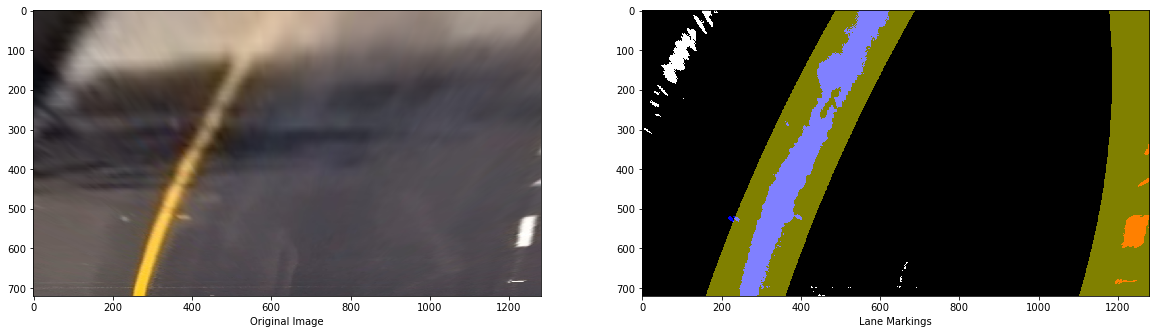

In [20]:
# Test the pipeline
for image in ipm_images:
    gradient_mask = gradient_pipeline(image)
    color_mask = color_pipeline(image)
    lane_mask  = np.zeros_like(color_mask)
    lane_mask [ ( color_mask >=0.5 ) | (gradient_mask >=0.5)] = 1
    
    
    leftx, lefty, rightx, righty = lane_points_finder(lane_mask)
    
    margin = 100
    minpix = 50
    
    # Get 2D polynomial
    left_fit, right_fit = get_lane_polynomial(leftx, lefty, rightx, righty)
    
    # Get X coordinates based on fit polynomial
    left_fitx, right_fitx = get_lane_xfits(lane_mask, 
                                           left_fit,
                                           right_fit,
                                           margin)
    
    # Get the Padded Lane Points using Margin
    left_line_pts, right_line_pts = get_padded_lane_points(lane_mask, 
                                                           left_fitx, 
                                                           right_fitx, 
                                                           margin)
    out_image = np.dstack((lane_mask, lane_mask, lane_mask))*255
    
    out_image[lefty, leftx] = [255, 0, 0]
    out_image[righty, rightx] = [0, 0, 255]
    disp_image = np.zeros_like(out_image)
    
    cv2.fillPoly(disp_image, np.int_([left_line_pts]), (0,255, 255))
    cv2.fillPoly(disp_image, np.int_([right_line_pts]), (0,255, 255))
    result = cv2.addWeighted(out_image,1.0, disp_image,0.5,0)
    
    result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(image,cmap='gray')
    plt.xlabel('Original Image')
    
    plt.subplot(122)
    plt.imshow(result, cmap='gray')
    plt.xlabel('Lane Markings')

    

### 9. Working with Video
The Pipeline after proper testing and tuning was used to annotate the video. The Flowchart is presented below

![Video Pipeline](./writeup_helpers/video_pipeline.png "Video Pipeline")


In [21]:
lane_output = 'project_annotated.mp4'
clip1 = VideoFileClip("./project_video.mp4")
annotated_clip = clip1.fl_image(annotate_frame)
%time annotated_clip.write_videofile(lane_output, audio=False)

[MoviePy] >>>> Building video project_annotated.mp4
[MoviePy] Writing video project_annotated.mp4


100%|█████████▉| 1260/1261 [01:59<00:00, 10.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_annotated.mp4 

CPU times: user 7min 27s, sys: 1min 1s, total: 8min 29s
Wall time: 2min


In [22]:
cv2.destroyAllWindows()
cv2.waitKey(1)

-1